In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import os
import glob
import itertools as it
import scipy.stats

In [54]:
IDIR = "../metfrag/"
DS = list(map(lambda _x: _x.split(".")[0], list(os.walk(os.path.join(IDIR, "mol_rt_info")))[0][2]))
print("Datasets", DS)

Datasets ['EQ_000', 'PR_000', 'RP_000', 'AU_000', 'BML_000', 'EQ_001', 'LU_000', 'LQB_000', 'EA_000', 'BS_000', 'UT_000', 'EA_001']


## Explore Retention Times

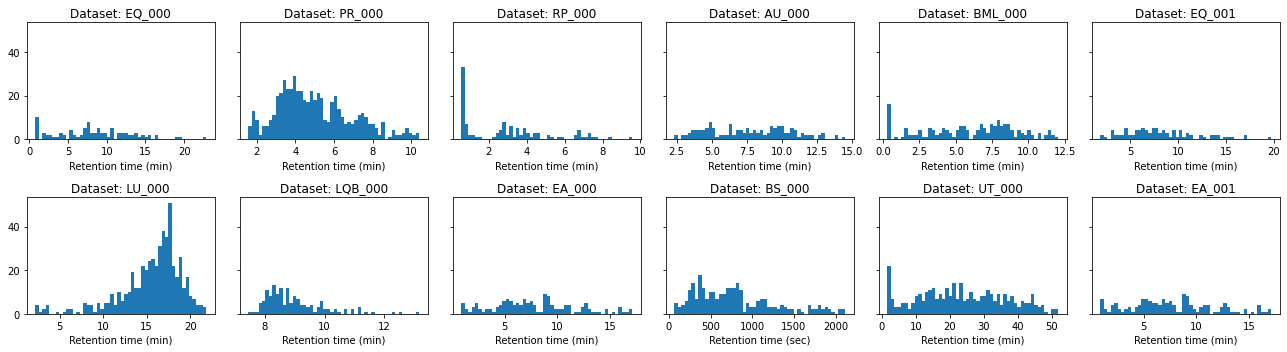

In [55]:
fig, axrr = plt.subplots(2, len(DS) // 2, sharey="all", sharex=False, figsize=(18, 5))
for idx, ds in enumerate(DS):
    _df = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    r, c = np.unravel_index(idx, axrr.shape)
    axrr[r, c].hist(_df["rt"], bins=50)
    axrr[r, c].set_title("Dataset: %s" % ds)
    axrr[r, c].set_xlabel("Retention time (%s)" % _df["rt_unit"][0])
plt.tight_layout()

The **retention time distribution** shows, that for 'RP_000', 'BML_000', 'UT_000' and (eventually) 'EQ_000' we should consider to remove early eluting molecules. 

In [56]:
ds_tuples_to_further_investigate = []

for ds1, ds2 in it.combinations(DS, 2):
    _df1 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds1 + ".csv"), index_col="inchikey")
    _df2 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds2 + ".csv"), index_col="inchikey")

    _ikey_inters = list(set(_df1.index) & set(_df2.index))
    
    if len(_ikey_inters) > 1:
        print("(%s,%s):\t%03d" % (ds1, ds2, len(_ikey_inters)), end="")
        
        if len(_ikey_inters) >= 10:
            _rt1 = _df1.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
            _rt2 = _df2.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
            _r, _p = scipy.stats.kendalltau(_rt1, _rt2)
            print("\tkend=%.5f" % _r, end="")
            if _p < 0.05:
                ds_tuples_to_further_investigate.append((ds1, ds2))
                print(" (*)")
            else:
                print("")
        else:
            print("")

(EQ_000,AU_000):	011	kend=0.74545 (*)
(EQ_000,LU_000):	018	kend=0.90132 (*)
(PR_000,RP_000):	009
(PR_000,AU_000):	002
(PR_000,BML_000):	035	kend=0.73109 (*)
(PR_000,LU_000):	010	kend=0.36803
(PR_000,BS_000):	027	kend=0.78348 (*)
(RP_000,AU_000):	002
(RP_000,BML_000):	004
(RP_000,EQ_001):	003
(RP_000,LU_000):	011	kend=0.83333 (*)
(RP_000,BS_000):	012	kend=0.93939 (*)
(AU_000,EQ_001):	010	kend=0.94388 (*)
(AU_000,LU_000):	054	kend=0.71024 (*)
(AU_000,EA_000):	047	kend=0.67504 (*)
(AU_000,BS_000):	002
(AU_000,EA_001):	050	kend=0.69266 (*)
(BML_000,LU_000):	013	kend=0.79487 (*)
(BML_000,EA_000):	002
(BML_000,BS_000):	018	kend=0.81699 (*)
(BML_000,EA_001):	002
(EQ_001,LU_000):	018	kend=0.72132 (*)
(EQ_001,BS_000):	003
(LU_000,EA_000):	043	kend=0.91445 (*)
(LU_000,BS_000):	016	kend=0.76151 (*)
(LU_000,EA_001):	045	kend=0.91739 (*)
(LQB_000,UT_000):	011	kend=0.74545 (*)
(EA_000,EA_001):	145	kend=1.00000 (*)


Many datasets show, even though small, overlap in the molecular structures meausred. The retention time order agreement, measured using Kendall's tau rank-correlation for datasets with at least ten molecules in common, lays between 0.66 and 1.0.

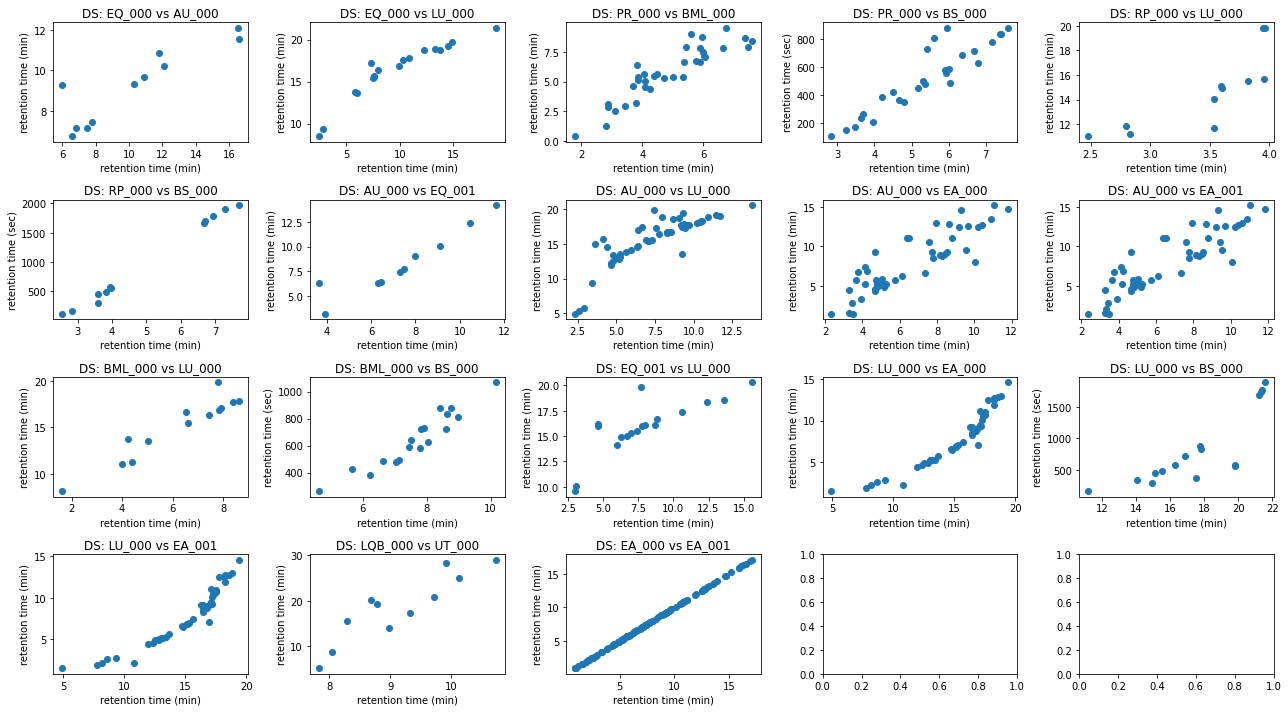

In [57]:
fig, axrr = plt.subplots(4, 17 // 3, figsize=(18, 10))
for idx, (ds1, ds2) in enumerate(ds_tuples_to_further_investigate):
    r, c = np.unravel_index(idx, axrr.shape)
    
    _df1 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds1 + ".csv"), index_col="inchikey")
    _df2 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds2 + ".csv"), index_col="inchikey")

    _ikey_inters = list(set(_df1.index) & set(_df2.index))
    
    _rt1 = _df1.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
    _rt2 = _df2.loc[_ikey_inters].drop_duplicates("smiles_iso", keep="first")["rt"]
    
    axrr[r, c].scatter(_rt1, _rt2)
    axrr[r, c].set_xlabel("retention time (%s)" % _df1["rt_unit"][0])
    axrr[r, c].set_ylabel("retention time (%s)" % _df2["rt_unit"][0])
    axrr[r, c].set_title("DS: %s vs %s" % (ds1, ds2))

plt.tight_layout()

## Explore Molecular Classes

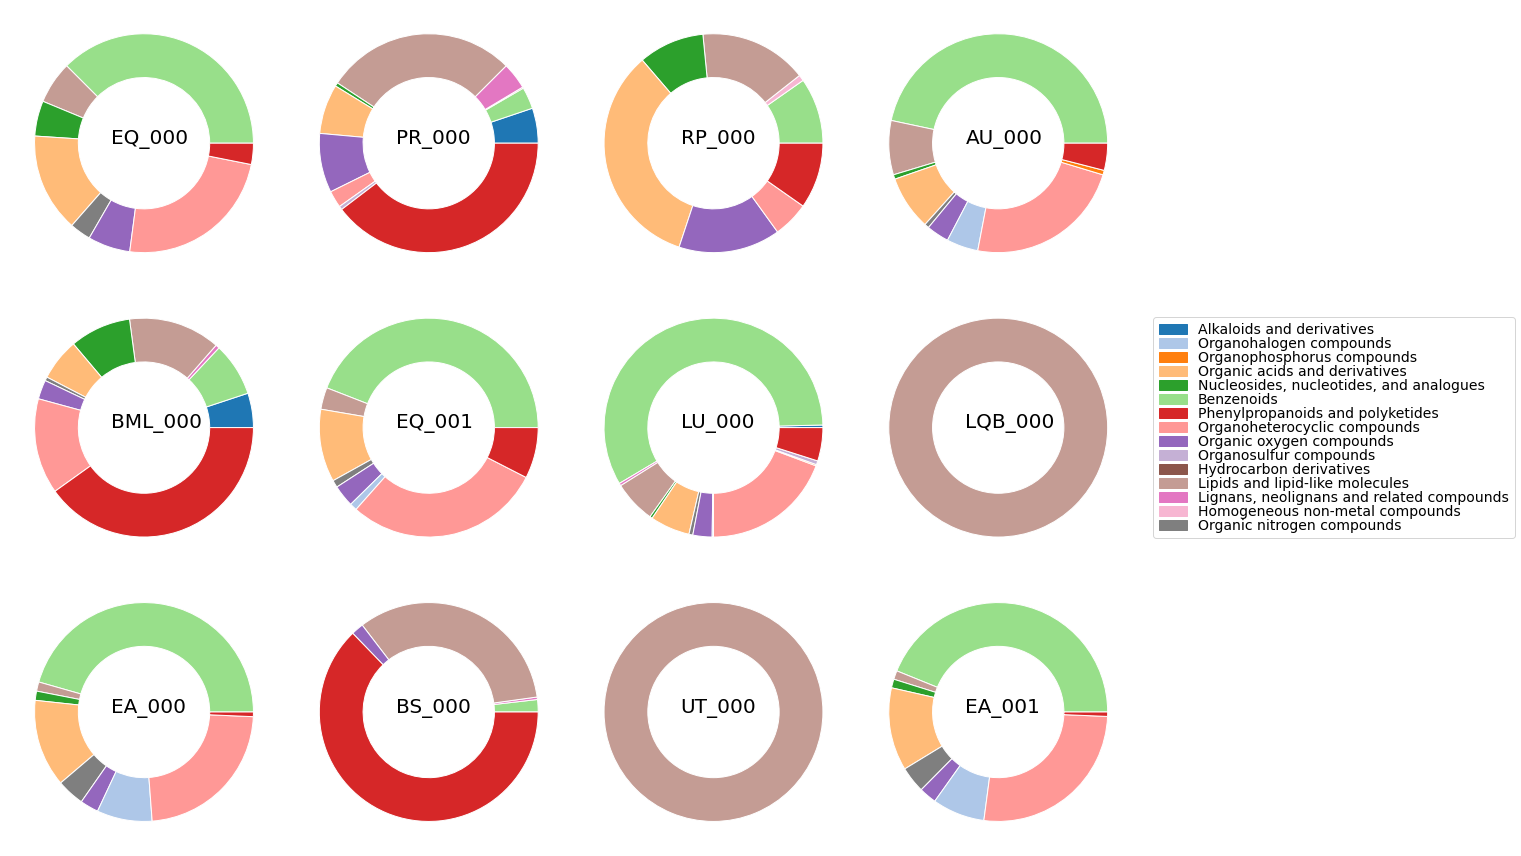

In [77]:
classyfire_level = "superclass"
classes, counts = [], []
classes_set = set()

# Determine the abundancy of all classes to unify colouring
for idx, ds in enumerate(DS):
    _df = pd.read_csv(os.path.join(IDIR, "classyfire", ds + ".classes"))
    _df = _df[_df[classyfire_level].notna()]
    _cls, _cts = np.unique(_df[classyfire_level], return_counts=True)
    classes.append(_cls)
    classes_set.update(_cls)
    counts.append(_cts)

# Get a color for each molecule class
cmap = plt.get_cmap("tab20")
colors = {_cls: _col for _cls, _col in zip(classes_set, cmap(np.arange(len(classes_set))))}

fig, axrr = plt.subplots(3, len(DS) // 3, sharey="all", sharex=False, figsize=(16, 12))
_h = []
for idx, ds in enumerate(DS):
    r, c = np.unravel_index(idx, axrr.shape)
    _h.append(axrr[r, c].pie(counts[idx], colors=[colors[_cls] for _cls in classes[idx]], radius=1,
                             wedgeprops=dict(width=0.4, edgecolor='w')))
    axrr[r, c].text(-0.3, 0, ds, fontsize=20)
    
plt.tight_layout()
plt.figlegend(handles=[mpatches.Patch(color=color, label=label) for label, color in colors.items()], 
              loc = 'center right', ncol=1, labelspacing=0., fontsize=14, bbox_to_anchor=(1.325, 0.5))

## Coverage with Colission Cross Section (CCS) Values

In [59]:
ccs_df = pd.read_excel("../CCS_database.xlsx", sheet_name="Negative_mode", usecols=["inchikey", "ccs", "adduct"])
ccs_df = ccs_df.assign(inchikey1=ccs_df["inchikey"].apply(lambda _x: _x.split("-")[0]))

print("CCS can be matched for:")
for ds in DS:
    _df = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    _df = _df.assign(inchikey1=_df["inchikey"].apply(lambda _x: _x.split("-")[0]))
    
    
    print("%s\t-\t%03d of %03d (inchikey) ; %03d of %03d (inchikey1)." % (
        ds, len(pd.merge(_df, ccs_df, on="inchikey")), len(_df), len(pd.merge(_df, ccs_df, on="inchikey1")), len(_df)))

CCS can be matched for:
EQ_000	-	001 of 096 (inchikey) ; 001 of 096 (inchikey1).
PR_000	-	020 of 560 (inchikey) ; 050 of 560 (inchikey1).
RP_000	-	039 of 113 (inchikey) ; 060 of 113 (inchikey1).
AU_000	-	003 of 150 (inchikey) ; 004 of 150 (inchikey1).
BML_000	-	014 of 177 (inchikey) ; 042 of 177 (inchikey1).
EQ_001	-	003 of 093 (inchikey) ; 004 of 093 (inchikey1).
LU_000	-	028 of 528 (inchikey) ; 032 of 528 (inchikey1).
LQB_000	-	000 of 148 (inchikey) ; 018 of 148 (inchikey1).
EA_000	-	002 of 147 (inchikey) ; 002 of 147 (inchikey1).
BS_000	-	031 of 274 (inchikey) ; 036 of 274 (inchikey1).
UT_000	-	000 of 349 (inchikey) ; 009 of 349 (inchikey1).
EA_001	-	002 of 155 (inchikey) ; 002 of 155 (inchikey1).


The coverage with CCS values is relatively low. It might be even lower, if we consider, that we need to match the adduct as well.

## Building a Retention Order Predictor

One possibility is to use the RT data provided by [RtPredTrainingData](https://github.com/michaelwitting/RtPredTrainingData) repository available on Github.

In [89]:
#RT_DATA_BASE_DIR = "/home/bach/Documents/doctoral/data/retentiontimes/RtPredTrainingData/"
#RT_DATA_DIR = os.path.join(RT_DATA_BASE_DIR, "processed_data")

#rt_ds_df = pd.read_csv(os.path.join(RT_DATA_BASE_DIR, "raw_data", "studies.txt"), sep="\t", index_col="id")
# rt_ds_df.head()

rt_ds_df = None

However, for now we stick to our old RT dataset (without stereo information though).

In [71]:
rt_df = pd.read_csv("../rt_training_data.tsv", sep="\t")
rt_df.head()

,inchikey1,smiles,dataset,rt,superclass,class
0,SEEPANYCNGTZFQ,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,Eawag_XBridgeC18,2.20,Benzenoids,Benzene and substituted derivatives
1,DKZBBWMURDFHNE,COc1cc(C=CC=O)ccc1O,Eugster_et_al_2015,6.35,Benzenoids,Phenols
2,LZPNXAULYJPXEH,COc1cccc(C=CC(=O)O)c1,RIKEN,1.67,Phenylpropanoids and polyketides,Cinnamic acids and derivatives
3,AFDXODALSZRGIH,COc1ccc(C=CC(=O)O)cc1,RIKEN,1.65,Phenylpropanoids and polyketides,Cinnamic acids and derivatives
4,FEGVSPGUHMGGBO,COc1ccccc1C=CC(=O)O,RIKEN,1.68,Phenylpropanoids and polyketides,Cinnamic acids and derivatives


We check the molecules classes covered by our RT training data:

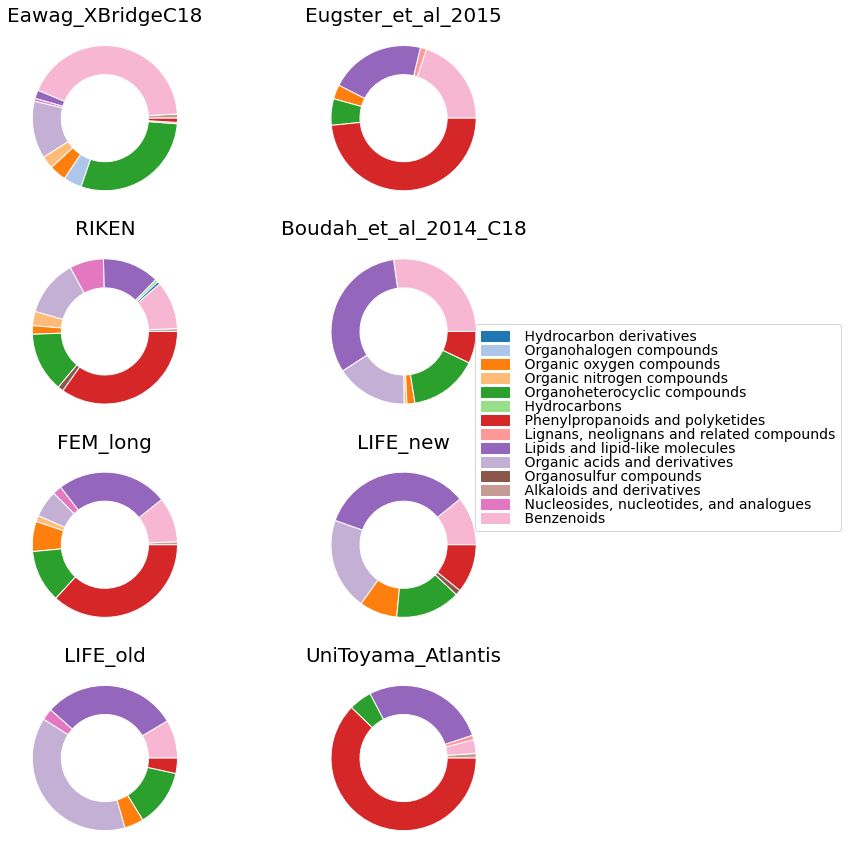

In [85]:
classyfire_level = "superclass"
classes, counts = [], []
classes_set = set()

# Determine the abundancy of all classes to unify colouring
for idx, ds in enumerate(rt_df.dataset.unique()):
    _cls, _cts = np.unique(rt_df[rt_df.dataset == ds][classyfire_level], return_counts=True)
    classes.append(_cls)
    classes_set.update(_cls)
    counts.append(_cts)

# Get a color for each molecule class
cmap = plt.get_cmap("tab20")
colors = {_cls: _col for _cls, _col in zip(classes_set, cmap(np.arange(len(classes_set))))}

fig, axrr = plt.subplots(4, 2, sharey="all", sharex=False, figsize=(10, 12))
_h = []
for idx, ds in enumerate(rt_df.dataset.unique()):
    r, c = np.unravel_index(idx, axrr.shape)
    _h.append(axrr[r, c].pie(counts[idx], colors=[colors[_cls] for _cls in classes[idx]], radius=1,
                             wedgeprops=dict(width=0.4, edgecolor='w')))
    # axrr[r, c].text(-0.3, 0, ds, fontsize=20)
    axrr[r, c].set_title(ds, fontsize=20)
    
plt.tight_layout()
plt.figlegend(handles=[mpatches.Patch(color=color, label=label) for label, color in colors.items()], 
              loc = 'center right', ncol=1, labelspacing=0., fontsize=14, bbox_to_anchor=(1.325, 0.5))

Get fingerprints

In [122]:
from rosvm.feature_extraction.featurizer_cls import CircularFPFeaturizer, EStateIndFeaturizer

fprinter = CircularFPFeaturizer(fp_mode="count", fp_type="ECFP", only_freq_subs=True, min_subs_freq=0.005,
                                output_dense_matrix=True)
# fprinter = EStateIndFeaturizer()

X = fprinter.fit_transform(rt_df.smiles.values)
print("Number of fingerprints: %d" % len(fprinter))

Number of fingerprints: 853


In [123]:
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC, Labels

y = Labels(rts=rt_df.rt, dss=rt_df.dataset)

In [132]:
rosvm = KernelRankSVC(C=8, kernel="generalized_tanimoto").fit(X, y)

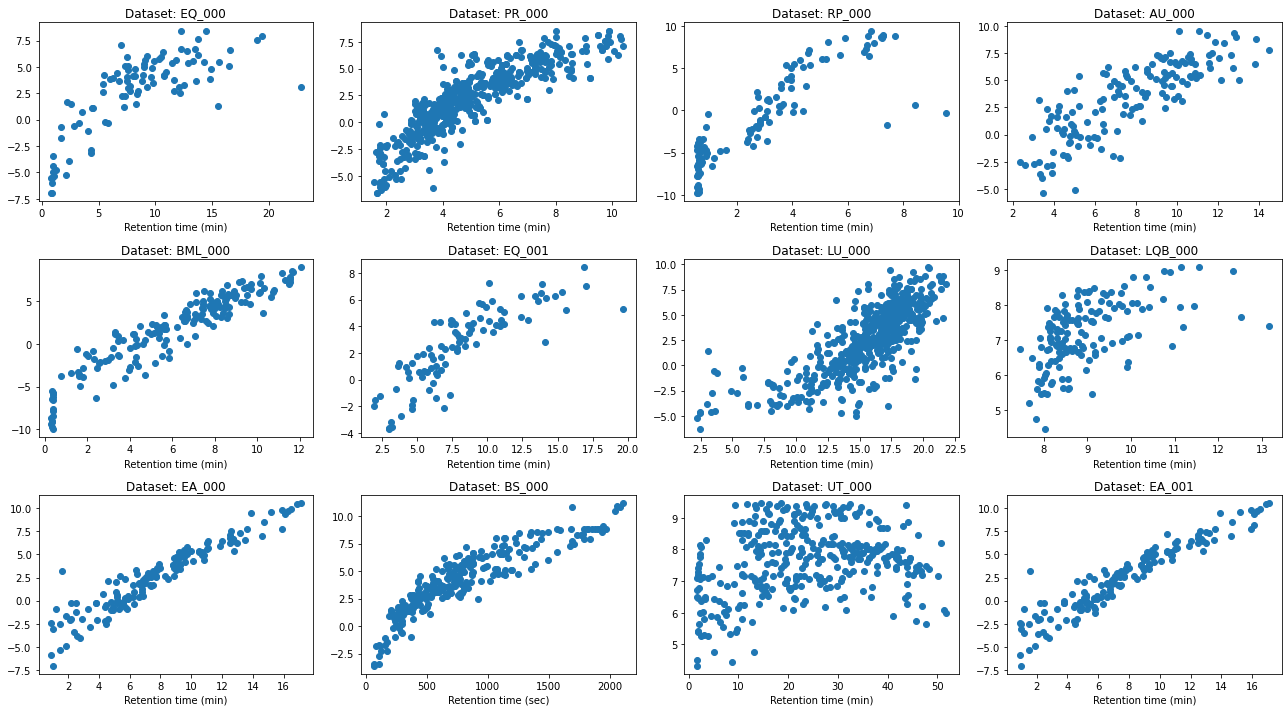

In [133]:
fig, axrr = plt.subplots(3, len(DS) // 3, sharey=False, sharex=False, figsize=(18, 10))
for idx, ds in enumerate(DS):
    _df = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    r, c = np.unravel_index(idx, axrr.shape)
    
    X_ds = fprinter.transform(_df.smiles_iso.values)
    
    axrr[r, c].scatter(_df["rt"], rosvm.predict_pointwise(X_ds))
    axrr[r, c].set_title("Dataset: %s" % ds)
    axrr[r, c].set_xlabel("Retention time (%s)" % _df["rt_unit"][0])
plt.tight_layout()

In [244]:
from sklearn.pipeline import FeatureUnion

# Feature union by molecule class
_feature = [
    (mcls, CircularFPFeaturizer(fp_mode="count", fp_type="FCFP", only_freq_subs=True, output_dense_matrix=True, 
                                radius=6))
    for mcls in classes_set
]
funion = FeatureUnion(_feature)

for trans_name, trans in funion.transformer_list:
    trans.fit(rt_df[rt_df.superclass == trans_name].smiles.values)
    print(trans_name, len(trans))
    
## Feature union by dataset
#_feature = [
#    (ds, CircularFPFeaturizer(fp_mode="count", fp_type="FCFP", only_freq_subs=True, output_dense_matrix=True, 
#                                radius=6))
#    for ds in rt_df.dataset.unique()
#]
#funion = FeatureUnion(_feature)
#
#for trans_name, trans in funion.transformer_list:
#    trans.fit(rt_df[rt_df.dataset == trans_name].smiles.values)
#    print(trans_name, len(trans))

 Hydrocarbon derivatives 29
 Organohalogen compounds 70
 Organic oxygen compounds 86
 Organic nitrogen compounds 58
 Organoheterocyclic compounds 58
 Hydrocarbons 13
 Phenylpropanoids and polyketides 126
 Lignans, neolignans and related compounds 231
 Lipids and lipid-like molecules 78
 Organic acids and derivatives 46
 Organosulfur compounds 67
 Alkaloids and derivatives 436
 Nucleosides, nucleotides, and analogues 196
 Benzenoids 50


In [245]:
X_union = funion.transform(rt_df.smiles.values)
print(X_union.shape)

(1465, 1544)


In [246]:
y = Labels(rts=rt_df.rt, dss=rt_df.dataset)
rosvm_union = KernelRankSVC(C=8, kernel="generalized_tanimoto").fit(X_union, y)

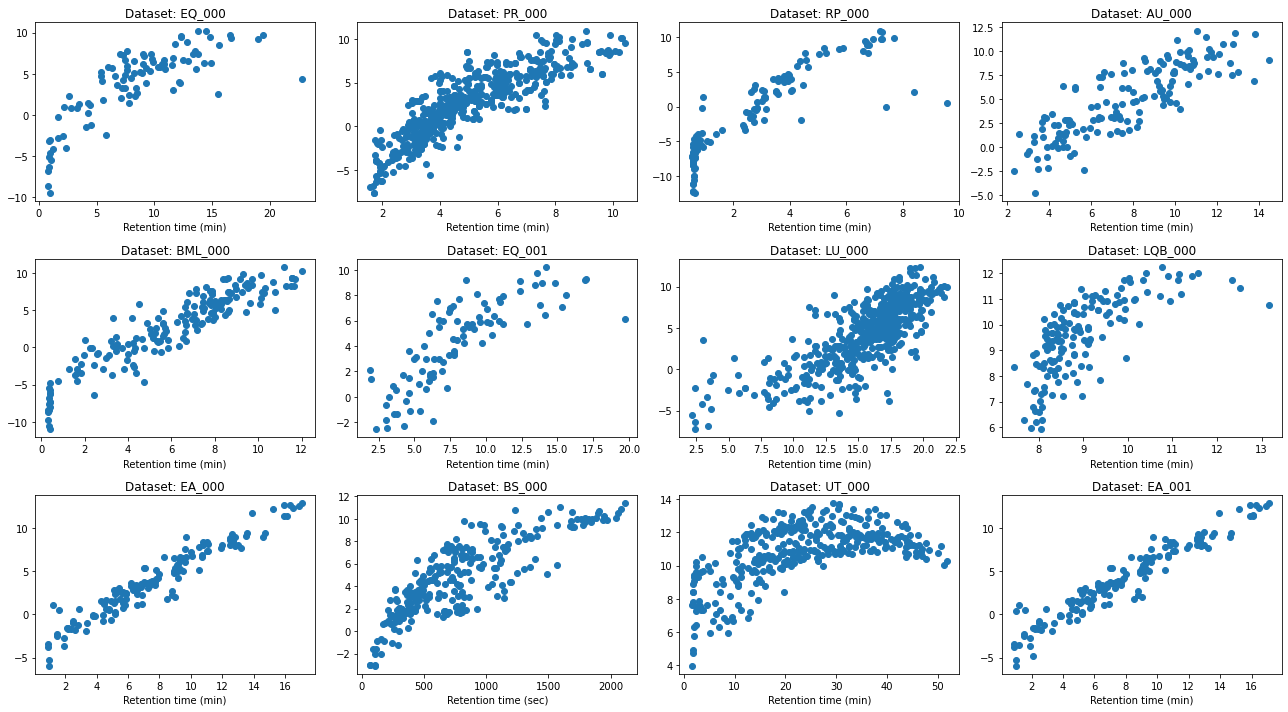

In [247]:
fig, axrr = plt.subplots(3, len(DS) // 3, sharey=False, sharex=False, figsize=(18, 10))
for idx, ds in enumerate(DS):
    _df = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    r, c = np.unravel_index(idx, axrr.shape)
    
    X_ds = funion.transform(_df.smiles_iso.values)
    
    axrr[r, c].scatter(_df["rt"], rosvm_union.predict_pointwise(X_ds))
    axrr[r, c].set_title("Dataset: %s" % ds)
    axrr[r, c].set_xlabel("Retention time (%s)" % _df["rt_unit"][0])
plt.tight_layout()

857


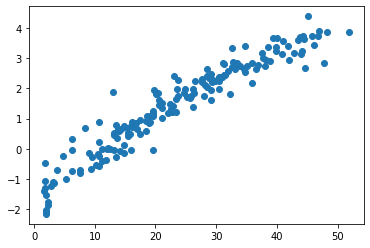

In [249]:
from sklearn.model_selection import GroupShuffleSplit

df__UT_000 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", "UT_000.csv"))

train, test = next(GroupShuffleSplit(n_splits=1, random_state=1002, test_size=0.5)
                   .split(df__UT_000, groups=df__UT_000.inchikey.apply(lambda _x: _x.split("-")[0])))

fprinter__UT_000 = CircularFPFeaturizer(fp_mode="count", fp_type="ECFP", only_freq_subs=True, min_subs_freq=0.01,
                                        output_dense_matrix=True, radius=6, use_chirality=True)
X__UT_000 = fprinter__UT_000.fit_transform(df__UT_000.iloc[train].smiles_iso.values)
print(len(fprinter__UT_000))
y__UT_000 = Labels(rts=df__UT_000.iloc[train].rt.values, dss=["UT_000"] * len(train))

rosvm__UT__000 = KernelRankSVC(C=1, kernel="minmax").fit(X__UT_000, y__UT_000)

y_pred__UT_000 = rosvm__UT__000.predict_pointwise(fprinter__UT_000.transform(df__UT_000.iloc[test].smiles_iso.values))

plt.scatter(df__UT_000.iloc[test].rt, y_pred__UT_000)

833


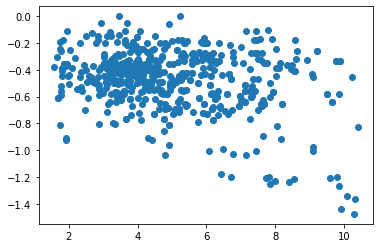

In [243]:
df__UT_000 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", "UT_000.csv"))
df__PR_000 = pd.read_csv(os.path.join(IDIR, "mol_rt_info", "PR_000.csv"))

fprinter__UT_000 = CircularFPFeaturizer(fp_mode="count", fp_type="ECFP", only_freq_subs=True, min_subs_freq=0.01,
                                        output_dense_matrix=True, radius=6, use_chirality=False)

X__UT_000 = fprinter__UT_000.fit_transform(df__UT_000.smiles_iso.values)
print(len(fprinter__UT_000))
y__UT_000 = Labels(rts=df__UT_000.rt.values, dss=["UT_000"] * len(df__UT_000))

rosvm__UT__000 = KernelRankSVC(C=1, kernel="minmax").fit(X__UT_000, y__UT_000)

y_pred__PR_000 = rosvm__UT__000.predict_pointwise(fprinter__UT_000.transform(df__PR_000.smiles_iso.values))

plt.scatter(df__PR_000.rt, y_pred__PR_000)

## Metabolite Identification Performance 

Here, we calcualte the Top-K accuracy for the MetFrag scored candidates lists.

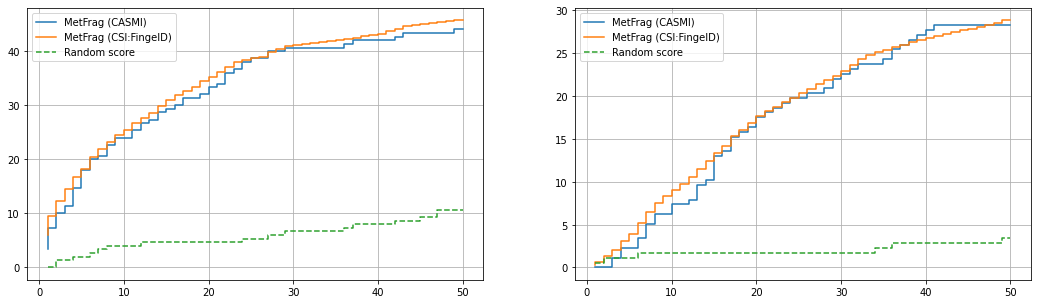

In [290]:
def simple_topk(cands):
    max_n_cands = np.max([cnd["n_cand"] for cnd in cands.values()])
    topk_acc = np.zeros(max_n_cands)
    for cnd in cands.values():
        topk_acc[cnd["index_of_correct_structure"]] += 1
    return np.cumsum(topk_acc) / len(cands) * 100

import gzip
from msmsrt_scorer.lib.evaluation_tools import get_topk_performance_casmi2016, get_topk_performance_csifingerid

only_correct_mf = False

fig, axrr = plt.subplots(1, 2, squeeze=False, sharex=True, figsize=(18, 5))

for ds_idx, ds in enumerate(["AU_000", "BML_000"]):
    _df_info = pd.read_csv(os.path.join(IDIR, "mol_rt_info", ds + ".csv"))
    cands = {}
    rand_scores = {}
    for idx, row in _df_info.iterrows():
        with gzip.open(os.path.join(IDIR, "results", ds, row["accession"] + ".csv.gz"), "rb") as _scores_file:
            _df_scores = pd.read_csv(_scores_file, index_col="Identifier")
        
        if only_correct_mf:
            with gzip.open(os.path.join(IDIR, "candidates", ds, row["accession"] + ".cands.gz"), "rb") as _cand_file:
                _df_cand = pd.read_csv(_cand_file, index_col="Identifier", usecols=["Identifier", "MolecularFormula"],
                                       sep="|")
                
            _df_scores = pd.merge(_df_scores, _df_cand, left_index=True, right_index=True)
            _df_scores = _df_scores[_df_scores.MolecularFormula == row["molecular_formula"]]
        
        cands[row["accession"]] = {"n_cand": _df_scores.shape[0],
                                   "index_of_correct_structure": _df_scores.index.get_loc(row["pubchem_id"]),
                                   "score": _df_scores.FragmenterScore.values}
        rand_scores[row["accession"]] = np.random.rand(cands[row["accession"]]["n_cand"])
        
    r, c = np.unravel_index(ds_idx, axrr.shape)
    _x = np.arange(1, 51)
    axrr[r, c].step(_x, get_topk_performance_casmi2016(cands)[1][:len(_x)], label="MetFrag (CASMI)")
    axrr[r, c].step(_x, get_topk_performance_csifingerid(cands)[1][:len(_x)], label="MetFrag (CSI:FingeID)")
    # axrr[r, c].plot(simple_topk(cands)[:50])
    axrr[r, c].step(_x, get_topk_performance_casmi2016(cands, rand_scores)[1][:len(_x)], '--', label="Random score")
    axrr[r, c].grid()
    axrr[r, c].legend()